# Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.
## Описание данных
Столбец text в нём содержит текст комментария, а toxic — целевой признак.
## Постановка задачи
### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
- загрузить библиотеки и данные;
- оценить распределение целевого признака;
- определение тестовой, валидационной и тренировочной выборок;
- вывод.
### [Шаг 2. Работа с моделями:](#section2)
- создание предсказания модели LinearClassifier;
- создание предсказания модели RandomForestClassifier;
- создание предсказания модели CatBoostClassifier;
- создание предсказания модели LGBMClassifier;
- создание предсказания модели DummyClassifier;
- анализ работы лучшей модели на тестовых данных;
- вывод.
### [Шаг 3. Общий вывод](#section3)

# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
# !pip install pymystem3

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils import shuffle

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

from pymystem3 import Mystem

m = Mystem()

import warnings

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(42)
RAND = 42

[nltk_data] Downloading package stopwords to C:\Users\Dream
[nltk_data]     Machines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим данные.

In [3]:
try:
    toxic_data = pd.read_csv('toxic_comments.csv')
except:
    toxic_data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        (
            (data.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(20, 10), legend=False, fontsize=10)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22)
        )
        print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
              'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(
                                                                       data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
    except:
        print('пропусков не осталось :) ')

In [5]:
# Функция изучения данных в таблице
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    display(data.sample(n=5))
    pass_value_barh(data)

Количество стобцов: 3
Количество строк: 159292
Дубликатов: 0


,Unnamed: 0,text,toxic
112795,112893,unblock| It was no me who was changing things ...,0
5608,5608,I think there's little doubt that there is tak...,0
37853,37899,"""\n\nNo they did not they have contact outside...",0
63849,63916,"""\n\n...not sure what such a """" has to do w/ a...",0
42979,43029,Big Brother Australia 2012 \nI see you have pa...,0


пропусков не осталось :) 


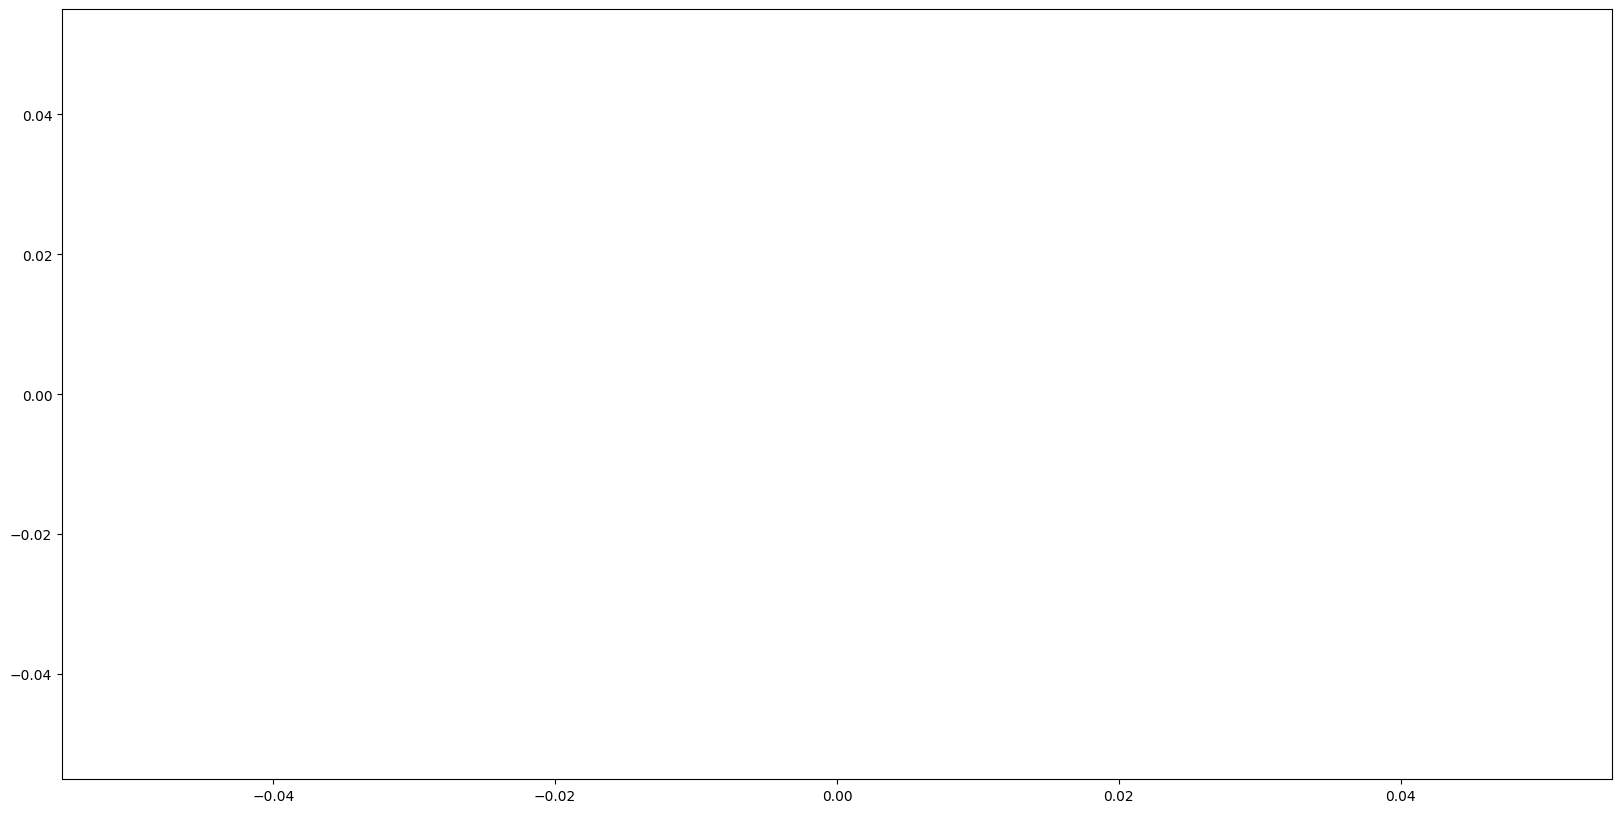

In [6]:
research_info(toxic_data)

В представленном датасете 159292 строк и 3 столбца. Текст сырой, его необходимо будет очистить и ламметизировать. Пропущенных значений нет. Целевым признаком является ['toxic'], оценка токсичности в комментарии ['text'], так же есть столбец ['Unnamed: 0'], который дублирует индексы в таблице.

In [7]:
toxic_data = toxic_data.drop(columns='Unnamed: 0')

Перед началом работы с текстом его необходимо отчистить от знаков препинания, привести к нижнему регистру, а после провести лемматизацию.

In [8]:
toxic_data['text'] = toxic_data['text'].apply(lambda sentence: re.sub(r'[^a-zA-Z]', ' ', sentence.lower()))

In [9]:
# Лемматизация корпуса
lemmatizer = WordNetLemmatizer()
toxic_data['text'] = toxic_data['text'].apply(
    lambda sentence: " ".join([lemmatizer.lemmatize(w, "n") for w in nltk.word_tokenize(sentence)]))

Проверим баланс классов в датасете.

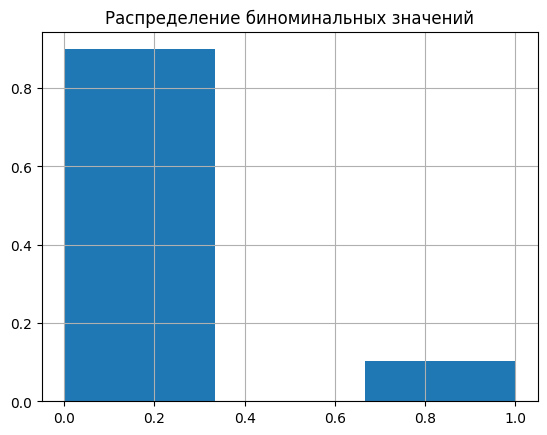

In [10]:
toxic_data['toxic'].hist(bins=3, weights=np.ones_like(toxic_data['toxic']) / len(toxic_data))
plt.title('Распределение биноминальных значений')
plt.show()

Очень большое распределение между признаками, которое разумно будет устранить с помощью функции upsample, после разделения данных на выборки.

In [11]:
train, test = train_test_split(toxic_data, test_size=0.2)
valid, test = train_test_split(test, test_size=0.5)

features_train = train.drop(['toxic'], axis=1)
target_train = train['toxic']

features_valid = valid.drop(['toxic'], axis=1)
target_valid = valid['toxic']

features_test = test.drop(['toxic'], axis=1)
target_test = test['toxic']

eval_set = [(features_valid, target_valid)]

In [12]:
# функция upsample для создания сбалансированности выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [13]:
features_up, target_up = upsample(features_train, target_train, repeat=6)

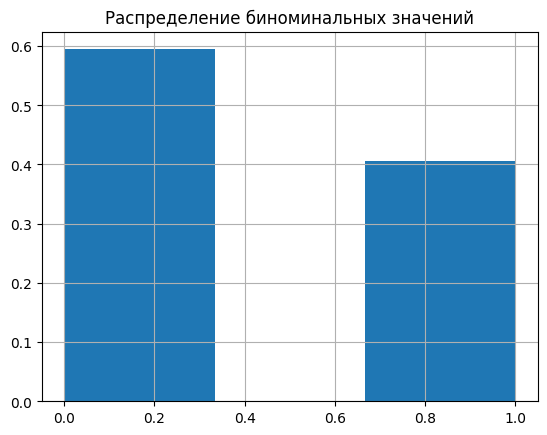

In [14]:
target_up.hist(bins=3, weights=np.ones_like(target_up.index) / len(target_up.index))
plt.title('Распределение биноминальных значений')
plt.show()

In [15]:
print('Размер тренировочной выборки (с дисбалансом) - {:.0%} ({} строк)'.format(
    features_train.shape[0] / toxic_data.shape[0], features_train.shape[0]))
print('Размер тренировочной выборки (без дисбаланса) - {:.0%} ({} строк)'.format(
    features_up.shape[0] / toxic_data.shape[0], features_up.shape[0]))
print('Размер валидационной выборки - {:.0%} ({} строк)'.format(features_valid.shape[0] / toxic_data.shape[0],
                                                                features_valid.shape[0]))
print('Размер тестовой выборки - {:.0%} ({} строк)'.format(features_test.shape[0] / toxic_data.shape[0],
                                                           features_test.shape[0]))

Размер тренировочной выборки (с дисбалансом) - 80% (127433 строк)
Размер тренировочной выборки (без дисбаланса) - 121% (192473 строк)
Размер валидационной выборки - 10% (15929 строк)
Размер тестовой выборки - 10% (15930 строк)


Получаем два набора обучающих данных (с дисбалансом и без него), а так же валидационную и тестовую выборки для сравнения параметров модели и её проверки.

Но перед началом обучения необходимо провести векторизацию корпуса текстов.

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfidf_train = count_tf_idf.fit_transform(features_train.values.astype('U').flatten())
tfidf_train_up = count_tf_idf.transform(features_up.values.astype('U').flatten())
tfidf_valid = count_tf_idf.transform(features_valid.values.astype('U').flatten())
tfidf_test = count_tf_idf.transform(features_test.values.astype('U').flatten())

In [17]:
print(tfidf_train.shape)
print(tfidf_train_up.shape)
print(tfidf_valid.shape)
print(tfidf_test.shape)

(127433, 138749)
(192473, 138749)
(15929, 138749)
(15930, 138749)


**Вывод**
- данные загружены;
- пропусков нет;
- тексты приведены к нужному формату и лемматизированы;
- получены наборы обучающих, валидационных и тестовых данных;
- для обучающих данных проведена балансировка;
- проведена векторизация корпусов текстов.

## Шаг 2. Работа с моделями <a class="anchor" id="section2"></a>

Создадим функции, которые позволят сравнить в конце все модели и следить за качеством по ходу работы.

In [18]:
# Генерация таблицы с метриками
def get_metrics(name: str = None,
                accuracy: str = None,
                f1: str = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['accuracy'] = [accuracy]
    df_metrics['f1_score'] = [f1]
    return df_metrics

Выберем следующие регрессоры для обучения модели:

- LogisticRegression;
- RandomForestRegressor;
- CatBoostRegressor;
- DummyRegressor.

**1. LogisticRegression**

In [19]:
lr = LogisticRegression(random_state=RAND, class_weight='balanced', n_jobs=-1)
lr.fit(tfidf_train, target_train)
predict_lr = lr.predict(tfidf_valid)
accuracy_lr = accuracy_score(predict_lr, target_valid)
f1_lr = f1_score(predict_lr, target_valid)
metrics = get_metrics('LinearRegression', accuracy_lr, f1_lr)

In [20]:
lr_up = LogisticRegression(random_state=RAND, class_weight='balanced', n_jobs=-1)
lr_up.fit(tfidf_train_up, target_up)

predict_lr_up = lr_up.predict(tfidf_valid)
accuracy_lr_up = accuracy_score(predict_lr_up, target_valid)
f1_lr_up = f1_score(predict_lr_up, target_valid)

metrics = metrics.append(get_metrics('LinearRegression_up', accuracy_lr_up, f1_lr_up))

**2. RandomForestClassifier**

In [21]:
rfc = RandomForestClassifier(random_state=RANDOM_VAL, n_jobs=-1)
rfc.fit(tfidf_train, target_train)
predict_rfc = rfc.predict(tfidf_valid)
accuracy_rfc = accuracy_score(predict_rfc, target_valid)
f1_rfc = f1_score(predict_rfc, target_valid)

metrics = metrics.append(get_metrics('RandomForestClassifier', accuracy_rfc, f1_rfc))

In [22]:
rfc_up = RandomForestClassifier(random_state=RANDOM_VAL, n_jobs=-1)
rfc_up.fit(tfidf_train_up, target_up)
predict_rfc_up = rfc_up.predict(tfidf_valid)
accuracy_rfc_up = accuracy_score(predict_rfc_up, target_valid)
f1_rfc_up = f1_score(predict_rfc_up, target_valid)

metrics = metrics.append(get_metrics('RandomForestClassifier_up', accuracy_rfc_up, f1_rfc_up))

**3. CatBoostClassifier**

In [24]:
model_cbr = CatBoostClassifier(random_seed=RAND,
                               allow_writing_files=False)

model_cbr.fit(tfidf_train,
              target_train,
              verbose=0)
predict_cbr = model_cbr.predict(tfidf_valid)
accuracy_cbr = accuracy_score(predict_cbr, target_valid)
f1_cbr = f1_score(predict_cbr, target_valid)

metrics = metrics.append(get_metrics('CatBoostRegressor', accuracy_cbr, f1_cbr))

In [25]:
model_cbr_up = CatBoostClassifier(random_seed=RAND,
                                  allow_writing_files=False)

model_cbr_up.fit(tfidf_train_up,
                 target_up,
                 verbose=0)
predict_cbr_up = model_cbr_up.predict(tfidf_valid)
accuracy_cbr_up = accuracy_score(predict_cbr_up, target_valid)
f1_cbr_up = f1_score(predict_cbr_up, target_valid)

metrics = metrics.append(get_metrics('CatBoostRegressor_up', accuracy_cbr_up, f1_cbr_up))

**4. DummyClassifier**

In [26]:
model_dc = DummyClassifier()
model_dc.fit(tfidf_train, target_train)
predict_dc = model_dc.predict(tfidf_valid)
accuracy_dc = accuracy_score(predict_dc, target_valid)
f1_dc = f1_score(predict_dc, target_valid)
metrics = metrics.append(get_metrics('DummyClassifier', accuracy_dc, f1_dc))

In [27]:
model_dc_up = DummyClassifier()
model_dc_up.fit(tfidf_train_up, target_up)
predict_dc_up = model_dc_up.predict(tfidf_valid)
accuracy_dc_up = accuracy_score(predict_dc_up, target_valid)
f1_dc_up = f1_score(predict_dc_up, target_valid)
metrics = metrics.append(get_metrics('DummyClassifier_up', accuracy_dc_up, f1_dc_up))

In [28]:
metrics = metrics.set_index('model')
metrics.style.background_gradient(cmap='coolwarm')

,accuracy,f1_score
model,,
LinearRegression,0.942118,0.749729
LinearRegression_up,0.943123,0.751372
RandomForestClassifier,0.952351,0.705243
RandomForestClassifier_up,0.951158,0.700999
CatBoostRegressor,0.957750,0.756600
CatBoostRegressor_up,0.953293,0.776308
DummyClassifier,0.899366,0.000000
DummyClassifier_up,0.899366,0.000000


Лучшей моделью по ключевой метрике f1 показала себя CatBoostRegressor, обученнная на сбалансированных данных. Дообучим модель на объединенных тестовых и валидационных данных и проверим качество выбранной модели на тестовых данных.

In [29]:
best_model = model_cbr_up
predict_best = best_model.predict(tfidf_test)
accuracy_best = accuracy_score(predict_best, target_test)
f1_best = f1_score(predict_best, target_test)
print('Точность модели CatBoostRegressor равна: {:.2f}'.format(accuracy_best))
print('F1 модели CatBoostRegressor равна: {:.2f}'.format(f1_best))

Точность модели CatBoostRegressor равна: 0.95
F1 модели CatBoostRegressor равна: 0.77


**Вывод**
Искомая модель найдена, скор полученный на тестовой выборке удовлетворяет условию, в данных не найдены пропуски и дубликаты. Лучшая модель основанна на алгоритме CatBoostRegressor.

## Шаг 3. Общий вывод <a class="anchor" id="section3"></a>
В ходе проделанной работы было выполнено:
1. В рамках подготовки данных:
- проведена предобработка данных;
- проведена лемматизация и векторизация корпусов текста;
- решена проблема дисбаланса данных.
2. В рамках работы с моделями:
- исследованы модели регрессии;
- получена таблица сравнительных признаков качества моделей;
- выбрана лучшая модель;
- её качество проверено на тестовой выборке;
- модель прошла проверку DummyRegressor.